In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import pearsonr
from Datasets import exp_set_dict_warm_order, exp_set_dict_wind_order, wind_order_forcings, all_runs_wind_order, all_runs_warm_order
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp
import pandas as pd

In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/uwas0134/Gemma/Analysis/Resubmission Figs/Functions_plotting.py'>

here
here


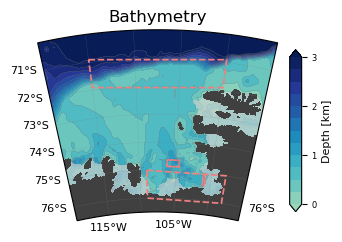

In [3]:
# Show locations of cross sections on bathymetry map
fp.plot_bathymetry_and_locs('AS_near', ['PIG', 'shelf_break','PITT','inner_shelf_corner'])
# plt.savefig('Plots/Figure_bathymetry_map_loc...'.png',dpi=600)

In [4]:
# Get PIG TC depths (only works if precalculated)

# set up data retrieval params
sets = ['ic_1995','ic_2001','ic_2008']
tcd_loc = 'PITT'
tc_temp = 0.5
forcings = wind_order_forcings #must match order of saved set numpy arrays (which is wind order)
#forcing_labs = [str(f)+'_x5' for f in forcings]

# get tcd_data
tcd_dict = {}
# contents of tcd_dict: run_name (e.g., 'run_forc_erai_2015_rep_ic_1995') --> [tcd_data,times]
for set_name in sets:
    print(set_name)
    set_tcd = np.load('../Saved Arrays/tcd_'+str(tc_temp)+'deg_tseries_'+tcd_loc+'_'+set_name+'.npy')
    set_times = np.load('../Saved Arrays/times_'+set_name+'.npy')
    for i in range(len(set_tcd)):
        if 'control' in set_name:
            run_name = 'Control'
        else:
            run_name = 'run_forc_erai_'+str(forcings[i])+'_rep_'+set_name
        tcd_dict[run_name] = set_tcd[i]

ic_1995
ic_2001
ic_2008


In [5]:
# calc undercurrent strength
# Get undercurrent strength for specified runs (either preload saved arrays or calc and save new arrays)

uc_region = 'shelf_break'

uc_dict = {}
for run in all_runs_wind_order:
    try:
        uc_tseries = np.load('../Saved Arrays/Undercurrent_tseries/'+run+'.npy')
        uc_dict[run] = uc_tseries
        print('precalculated undercurrent strength found for', run)
    except:
        print('Calculating new undercurrent strength for',run,'...')
        uc_tseries = fda.calc_undercurrent_strength(run, uc_region)
        fname = '../Saved Arrays/Undercurrent_tseries/'+run+'.npy'
        np.save(fname, uc_tseries)
        print('../Saved array as', fname)
        uc_dict[run] = uc_tseries

precalculated undercurrent strength found for run_forc_erai_2015_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1991_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1982_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1994_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1992_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1984_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2009_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2003_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_1989_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2011_rep_ic_1995
precalculated undercurrent strength found for run_forc_erai_2015_rep_ic_2001
precalculated undercurrent strength found for run_forc_erai_1991_rep_ic_2001
precalculated undercurrent strength found for run_forc_erai_1982_rep_ic_2001

In [6]:
# save undercurrent strength simple, based on lat/lon with max depth-avgd U from 0m+

def calc_uc(run, region):
    """
    For a given run, calc uc strength and bt and bc components. 
    Find lat/lon with the max time-mean depth-avgd U. 
    For each timestep, 
    UC = max U in the water column. 
    BT = depth-avgd U at that loc. 
    BC = UC - BT

    
    """

    # get experiment U data in specified region
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_U = flo.load_experiment_ds(run, 'all', 'state_3d_set2').UVELMASS
    exp_U = exp_U.isel(time=slice(0,60))
    exp_U_sb = exp_U.sel(lat=slice(lat1, lat2), lon_at_f_loc=slice(lon1, lon2),depth =slice(0,-2000))
    exp_U_depth_avg = exp_U_sb.mean(dim='depth')
    exp_U_depth_time_avg = exp_U_depth_avg.mean(dim='time')

    # Find the indices of the maximum depth_avged and time-avged value 
    max_idx = np.unravel_index(exp_U_depth_time_avg.argmax(), exp_U_depth_time_avg.shape)
    # Extract the lat, longitude corresponding to the maximum value
    max_lat = exp_U_depth_time_avg.lat[max_idx[0]].item()
    max_lon = exp_U_depth_time_avg.lon_at_f_loc[max_idx[1]].item()
    print('UC lat/lon:', max_lat, max_lon) #generally around -71.25, -106.67
    uc_loc_U = exp_U_sb.sel(lat=max_lat, lon_at_f_loc = max_lon)
    uc_depth_avg_U = exp_U_depth_avg.sel(lat=max_lat, lon_at_f_loc = max_lon)

    # calc uc timeseries at max location
    uc_tseries = np.zeros((60,))
    
    #form tseries at the peak location with max U and depth-avgd U
    for t in range(60):
        uc_loc_U_t = uc_loc_U.isel(time=t)

        # uc strength = max U 
        uc_max_U_t = uc_loc_U_t.max()
        uc_tseries[t] = uc_max_U_t.values

    bt_tseries = np.array(uc_depth_avg_U)
    bc_tseries = uc_tseries - bt_tseries

    return uc_tseries, bt_tseries, bc_tseries


uc_dict = {}
uc_bt_dict = {}
uc_bc_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        uc_run = np.load('../Saved Arrays/Undercurrent_tseries_3/'+run+'_uc.npy')
        bt_run = np.load('../Saved Arrays/Undercurrent_tseries_3/'+run+'_bt.npy')
        bc_run = np.load('../Saved Arrays/Undercurrent_tseries_3/'+run+'_bc.npy')
        print('precalculated bt/bc components found for run',run)
    except:
        print('calculating and saving new bt/bc components for run',run)
        uc_run, bt_run, bc_run = calc_uc3(run,uc_region)
        np.save('../Saved Arrays/Undercurrent_tseries_3/'+run+'_uc.npy', uc_run)
        np.save('../Saved Arrays/Undercurrent_tseries_3/'+run+'_bt.npy', bt_run)
        np.save('../Saved Arrays/Undercurrent_tseries_3/'+run+'_bc.npy', bc_run)
    uc_dict[run] = uc_run
    uc_bt_dict[run] = bt_run
    uc_bc_dict[run] = bc_run

run_forc_erai_2015_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated bt/bc components found for run run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precal

warm runs ['run_forc_erai_1982_rep_ic_2001', 'run_forc_erai_1984_rep_ic_2001', 'run_forc_erai_1989_rep_ic_2001', 'run_forc_erai_1992_rep_ic_2001']
cool runs ['run_forc_erai_1994_rep_ic_2001', 'run_forc_erai_2003_rep_ic_2001', 'run_forc_erai_2009_rep_ic_2001', 'run_forc_erai_1991_rep_ic_2001']
uc done
bt done
bc done


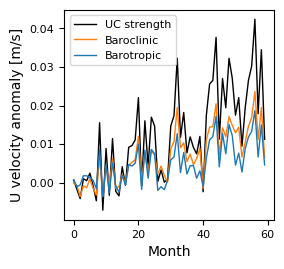

In [7]:
# calc composites and anomalies for uc and components 

exp_set = 'ic_2001'
exp_set_runs = exp_set_dict_wind_order[exp_set] 
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)

# undercurrent
warm_comp_uc = np.mean(np.array([uc_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc = np.mean(np.array([uc_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc = np.mean(np.array([uc_dict[run] for run in exp_set_runs]),axis=0)
print('uc done')

#barotropic component
warm_comp_uc_bt = np.mean(np.array([uc_bt_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc_bt = np.mean(np.array([uc_bt_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc_bt = np.mean(np.array([uc_bt_dict[run] for run in exp_set_runs]),axis=0)
print('bt done')

# baroclinic component
warm_comp_uc_bc = np.mean(np.array([uc_bc_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc_bc = np.mean(np.array([uc_bc_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc_bc = np.mean(np.array([uc_bc_dict[run] for run in exp_set_runs]),axis=0)
print('bc done')

# plot warm composite anomaly undercurrent and its components using method 2

warm_comp_uc_anom = warm_comp_uc - ens_mean_uc
warm_comp_bt_anom = warm_comp_uc_bt - ens_mean_uc_bt
# warm_comp_bc_anom = warm_comp_uc_anom - warm_comp_bt_anom 
warm_comp_bc_anom = warm_comp_uc_bc - ens_mean_uc_bc #this is the same as the above line, which is good.

lw = 1
plt.figure(figsize=(3,3))
plt.plot(warm_comp_uc_anom,label='UC strength',color='k',linewidth=lw)
plt.plot(warm_comp_bc_anom, label='Baroclinic',color='tab:orange',linewidth=lw)
plt.plot(warm_comp_bt_anom, label='Barotropic',color='tab:blue',linewidth=lw)

plt.ylabel('U velocity anomaly [m/s]')
plt.legend(fontsize=8)
plt.xlabel('Month')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplots_adjust(top=0.9,bottom=0.2,right=0.95,left=0.25)
plt.savefig('Plots/Figure_ED_4b_uc_decomp.png',dpi=400)

In [8]:
# Calc temps at a given loc at a given depth

def calc_temp(run, region, depth):
    exp_temp_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').THETA
    exp_temp_full = exp_temp_full.isel(time=slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_temp_reg = exp_temp_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_temp_reg = exp_temp_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_temp_z = exp_temp_reg.sel(depth=depth,method='nearest')
    exp_temp = exp_temp_z.mean(dim='lat')
    exp_temp = exp_temp.mean(dim='lon')

    return exp_temp.values


# temp_loc = 'PIG'
temp_loc = 'inner_shelf_corner'
temp_depth = -300
temp_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        temp_run = np.load('../Saved Arrays/Temp_tseries/'+str(temp_depth)[1:]+'m_'+run+'_'+temp_loc+'.npy')
        print('precalculated temps found for', run)
    except:
        temp_run = calc_temp(run, temp_loc, temp_depth)
        fname = '../Saved Arrays/Temp_tseries/'+str(temp_depth)[1:]+'m_'+run+'_'+temp_loc+'.npy'
        np.save(fname, temp_run)
        print('Saved array as', fname)
    
    temp_dict[run] = temp_run

run_forc_erai_2015_rep_ic_1995
precalculated temps found for run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated temps found for run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated temps found for run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated temps found for run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated temps found for run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated temps found for run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated temps found for run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated temps found for run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated temps found for run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precalculated temps found for run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
precalculated temps found for run_forc_erai_2015_

In [9]:
# Calc salinity in location at a given depth

def calc_salinity(run, region, depth):
    exp_sal_full = flo.load_experiment_ds(run, 'all', 'state_3d_set2').SALT
    exp_sal_full = exp_sal_full.isel(time=slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_sal_reg = exp_sal_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_sal_reg = exp_sal_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_sal_z = exp_sal_reg.sel(depth=depth,method='nearest')
    exp_sal = exp_sal_z.mean(dim='lat')
    exp_sal = exp_sal.mean(dim='lon')

    return exp_sal.values


# sal_loc = 'PIG'
sal_loc = 'inner_shelf_corner'
sal_depth = -100 #0 PIG and inner_Shelf_corner and -100 inner_shelf_corner are saved 
sal_dict = {}
for run in all_runs_wind_order:
    print(run)
    try:
        sal_run = np.load('../Saved Arrays/sal_tseries/'+str(sal_depth)+'m_'+run+'_'+sal_loc+'.npy')
        print('precalculated sals found for', run)
    except:
        sal_run = calc_salinity(run, sal_loc, sal_depth)
        fname = '../Saved Arrays/sal_tseries/'+str(sal_depth)+'m_'+run+'_'+sal_loc+'.npy'
        np.save(fname, sal_run)
        print('Saved array as', fname)
    
    sal_dict[run] = sal_run

run_forc_erai_2015_rep_ic_1995
precalculated sals found for run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
precalculated sals found for run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
precalculated sals found for run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
precalculated sals found for run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
precalculated sals found for run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
precalculated sals found for run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
precalculated sals found for run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
precalculated sals found for run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
precalculated sals found for run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
precalculated sals found for run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
precalculated sals found for run_forc_erai_2015_rep_ic_2001

In [10]:
# Calc SI area in specified region

def calc_SIarea(run, region):
    exp_sia_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').SIarea
    exp_sia_full = exp_sia_full.isel(time=slice(0, 60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_sia_reg = exp_sia_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_sia_reg = exp_sia_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2)) 
                               
    exp_sia = exp_sia_reg.mean(dim='lat')
    exp_sia = exp_sia.mean(dim='lon')

    return exp_sia


# sia_loc = 'PIG'
sia_loc = 'inner_shelf_corner'
sia_dict = {}
for run in all_runs_wind_order:
    print(run)
    sia_run = calc_SIarea(run, sia_loc)
    sia_dict[run] = sia_run



run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [11]:
# Calculate ocean surface FW flux timeseries near PIG (+ down, + increases salinity)
def calc_fw_flux(run, region):
    exp_fw_full = flo.load_experiment_ds(run, 'all', 'state_2d_set2').oceFWflx
    exp_fw_full = exp_fw_full.isel(time = slice(0,60))
    try:
        lati1, lati2, loni1, loni2 = fda.trough_idx_dict[region]
        exp_fw_reg = exp_fw_full.isel(lat=slice(lati1, lati2), lon=slice(loni1, loni2))
    except:
        lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
        exp_fw_reg = exp_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_fw = exp_fw_reg.mean(dim='lat')
    exp_fw = exp_fw.mean(dim='lon')

    return exp_fw


# fw_loc = 'PIG'
fw_loc = 'inner_shelf_corner'
fw_dict = {}
for run in all_runs_wind_order:
    print(run)
    fw_run = calc_fw_flux(run, fw_loc)
    fw_dict[run] = fw_run



run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [12]:
# Calculate ice shelf FW flux timeseries under PIG 

# (ignores zeros, where ice shelf does not exist)
# positive upward

def calc_ice_fw_flux(run, region):
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[region]
    exp_ice_fw_full = flo.load_experiment_ds(run, 'all', 'iceshelf_state_set2').SHIfwFlx
    exp_ice_fw_reg = exp_ice_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_ice_fw_reg = exp_ice_fw_reg.isel(time=slice(0, 60))
    # ignore zeros by replacing with nans, then calc nanmean
    exp_ice_fw_nan = exp_ice_fw_reg.where(exp_ice_fw_reg != 0)
    exp_ice_fw_mean = exp_ice_fw_nan.mean(dim='lat')
    exp_ice_fw_mean = exp_ice_fw_mean.mean(dim='lon')
    
    return exp_ice_fw_mean


# ice_fw_loc = 'PIG_shelf'
ice_fw_loc = 'inner_shelf_corner'
ice_fw_dict = {}
for run in all_runs_wind_order:
    print(run)
    ice_fw_run = calc_ice_fw_flux(run, ice_fw_loc)
    ice_fw_dict[run] = ice_fw_run


run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


In [14]:
# Calc warm composite and cool composites and filter out high freq (either sub-annual or sub-seasonal)

exp_set = 'ic_1995'
exp_set_runs = exp_set_dict_wind_order[exp_set] #order doesn't matter, it uses the runs as dict keys
warm_order_runs = exp_set_dict_warm_order[exp_set]
warm_runs = warm_order_runs[0:4]
cool_runs = warm_order_runs[4:8]
print('warm runs',warm_runs)
print('cool runs',cool_runs)

warm_comp_temp = np.mean(np.array([temp_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_temp = np.mean(np.array([temp_dict[run] for run in cool_runs]),axis=0)
ens_mean_temp = np.mean(np.array([temp_dict[run] for run in exp_set_runs]),axis=0)

warm_comp_sal = np.mean(np.array([sal_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_sal = np.mean(np.array([sal_dict[run] for run in cool_runs]),axis=0)
ens_mean_sal = np.mean(np.array([sal_dict[run] for run in exp_set_runs]),axis=0)

# Sea ice area
warm_comp_sia = np.mean(np.array([sia_dict[run] for run in warm_runs]),axis=0)
cool_comp_sia = np.mean(np.array([sia_dict[run] for run in cool_runs]),axis=0)
ens_mean_sia = np.mean(np.array([sia_dict[run] for run in exp_set_runs]),axis=0)

#ocean FW
# warm_comp_fw = np.mean(np.array([fw_dict[run] for run in warm_runs]),axis=0)
# cool_comp_fw = np.mean(np.array([fw_dict[run] for run in cool_runs]),axis=0)
# ens_mean_fw = np.mean(np.array([fw_dict[run] for run in exp_set_runs]),axis=0)
# print('fw done')

warm_comp_ice_fw = np.mean(np.array([ice_fw_dict[run] for run in warm_runs]),axis=0)
cool_comp_ice_fw = np.mean(np.array([ice_fw_dict[run] for run in cool_runs]),axis=0)
ens_mean_ice_fw = np.mean(np.array([ice_fw_dict[run] for run in exp_set_runs]),axis=0)

# undercurrent
warm_comp_uc = np.mean(np.array([uc_dict[run] for run in warm_runs]),axis=0) #shape 60
cool_comp_uc = np.mean(np.array([uc_dict[run] for run in cool_runs]),axis=0)
ens_mean_uc = np.mean(np.array([uc_dict[run] for run in exp_set_runs]),axis=0)
print('uc done')


warm runs ['run_forc_erai_1982_rep_ic_1995', 'run_forc_erai_1984_rep_ic_1995', 'run_forc_erai_1989_rep_ic_1995', 'run_forc_erai_1992_rep_ic_1995']
cool runs ['run_forc_erai_1994_rep_ic_1995', 'run_forc_erai_2003_rep_ic_1995', 'run_forc_erai_2009_rep_ic_1995', 'run_forc_erai_1991_rep_ic_1995']
uc done


In [15]:
# convert ice shelf fw flux to melt rate
#convert to m/yr
rho_fw = 1000
sec_per_year = 60*60*24*365.25
warm_comp_melt_rate = warm_comp_ice_fw / rho_fw * sec_per_year
cool_comp_melt_rate = warm_comp_ice_fw / rho_fw * sec_per_year
ens_mean_melt_rate = ens_mean_ice_fw / rho_fw * sec_per_year


ic_1995
inner_shelf_corner
year 1 Sea ice area: 0.1637
Year 1 annual mean SIA anom: 0.02, a 11.73% change from EM yr 1
Year 2 annual mean SIA anom: 0.05, a 28.76% change from EM yr 1
Year 3 annual mean SIA anom: 0.05, a 33.27% change from EM yr 1
Year 4 annual mean SIA anom: 0.05, a 30.45% change from EM yr 1
Year 5 annual mean SIA anom: 0.05, a 28.97% change from EM yr 1
inner_shelf_corner
year 1 ice melt rate: -13.74141407
Year 1 annual mean melt rate anom: 0.37431559, a -2.72% change from EM yr 1
Year 2 annual mean melt rate anom: 1.72755325, a -12.57% change from EM yr 1
Year 3 annual mean melt rate anom: 2.76952291, a -20.15% change from EM yr 1
Year 4 annual mean melt rate anom: 3.73313785, a -27.17% change from EM yr 1
Year 5 annual mean melt rate anom: 4.62310886, a -33.64% change from EM yr 1


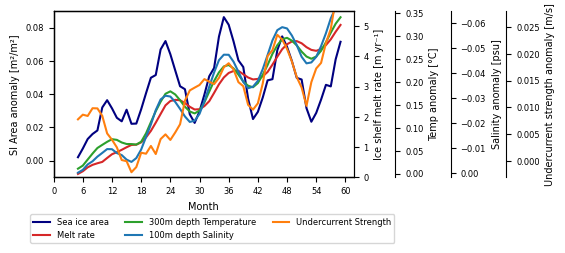

In [26]:
# plot sea ice, temp, heat flux, and undercurrent anomalies, showing trends

print(exp_set)
fig,ax0 = plt.subplots(1,1,figsize=(6,2.6))
window = 6
ls = 7

# Plot SI area on left y axis
warm_comp_sia_anom = warm_comp_sia - ens_mean_sia
sia_tseries = pd.Series(warm_comp_sia_anom).rolling(window=window).mean()
ax0.plot(sia_tseries,label='Sea ice area',color='navy')
ax0.set_ylim([-0.01,0.09])
ax0.set_ylabel('SI Area anomaly [m²/m²]',fontsize=ls)

# Plot ice melt rate
# convert ice shelf fw flux to melt rate
#convert to m/yr
rho_fw = 1000
sec_per_year = 60*60*24*365.25
warm_comp_melt_rate = warm_comp_ice_fw / rho_fw * sec_per_year
cool_comp_melt_rate = warm_comp_ice_fw / rho_fw * sec_per_year
ens_mean_melt_rate = ens_mean_ice_fw / rho_fw * sec_per_year

ax1 = ax0.twinx()
ax1.spines['right'].set_position(('outward',0)) 
melt_rate_anom = pd.Series(warm_comp_melt_rate - ens_mean_melt_rate).rolling(window=window).mean()
ax1.plot(-melt_rate_anom,label='Melt rate',color='tab:red')
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
ax1.set_ylim([0,5.5])
ax1.set_ylabel('Ice shelf melt rate anomaly [m yr⁻¹]',fontsize=ls)

# Plot ice fw flux
# ax1 = ax0.twinx()
# ax1.spines['right'].set_position(('outward',0)) 
# ice_fw_tseries = pd.Series(warm_comp_ice_fw - ens_mean_ice_fw).rolling(window=window).mean()
# ax1.plot(-ice_fw_tseries,label='Ice FW flux',color='tab:red')
# ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
# ax1.set_ylim([-0.00001,0.000179])
# ax1.set_ylabel('Ice shelf FW flux [kg m⁻²s⁻¹]',fontsize=ls)

# Plot temperature
ax2 = ax0.twinx()
ax2.spines['right'].set_position(('outward', 30)) 
temp_tseries = pd.Series(warm_comp_temp - ens_mean_temp).rolling(window=window).mean()
ax2.plot(temp_tseries,label=str(temp_depth)[1:]+'m depth Temperature',color='tab:green')
ax2.set_ylim([-0.008,0.355])
ax2.set_ylabel('Temp anomaly [°C]',fontsize=ls)

# Plot salinity anomalies
ax3 = ax0.twinx()
ax3.spines['right'].set_position(('outward', 70)) 
sal_tseries = pd.Series(warm_comp_sal - ens_mean_sal).rolling(window=window).mean()
ax3.plot(sal_tseries,label=str(sal_depth)[1:]+'m depth Salinity',color='tab:blue')
ax3.set_ylim([-0.065,0.0018])
ax3.invert_yaxis() #invert sal so freshening matches peaks
ax3.set_ylabel('Salinity anomaly [psu]',fontsize=ls)

axes = [ax0,ax1,ax2, ax3]

uc_tseries = pd.Series(warm_comp_uc - ens_mean_uc).rolling(window=window).mean()
ax4 = ax0.twinx()
ax4.spines['right'].set_position(('outward', 110)) 
ax4.plot(uc_tseries,label='Undercurrent Strength',color='tab:orange')
ax4.set_ylabel('Undercurrent strength anomaly [m/s]',fontsize=ls)
axes.append(ax4)
ax4.set_ylim([-0.003,0.028])


# Add legend for all axes

for ax in axes:
    lines, labels = ax.get_legend_handles_labels()
    if ax == ax0:
        all_lines = lines
        all_labels = labels
    else:
        all_lines += lines
        all_labels += labels
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.tick_params(axis='both',labelsize=6)
ax0.legend(all_lines, all_labels, loc='lower right', ncol=3,bbox_to_anchor=[1.15,-.42],fontsize=6)

# ax0.set_title('Warm Composite '+exp_set+' anomalies, '+str(window)+'-month rm')
ax0.set_xlabel('Month',fontsize=ls)
ax0.set_xticks(np.arange(0,66,6))


# show values for sea ice area changes
yr1_em_sia = np.mean(ens_mean_sia[0:12])
print(sia_loc)
print('year 1 Sea ice area: {:.4f}'.format(yr1_em_sia))
for i in range(5):
    yr_i_sia_anom = np.mean(warm_comp_sia_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean SIA anom: {:.2f}'.format(yr_i_sia_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_sia_anom/yr1_em_sia)*100))

# # show values for oceFWflux changes
# yr1_em_fw = np.mean(ens_mean_fw[0:12])
# print(fw_loc)
# print('year 1 oce FW: {:.8f}'.format(yr1_em_fw))
# warm_comp_fw_anom = warm_comp_fw - ens_mean_fw
# for i in range(5):
#     yr_i_fw_anom = np.mean(warm_comp_fw_anom[i*12:i*12+12])
#     print('Year '+str(i+1)+' annual mean oce FWflux anom: {:.8f}'.format(yr_i_fw_anom)\
#          +', a {:.2f}% change from EM yr 1'.format((yr_i_fw_anom/yr1_em_fw)*100))

# show values for ice melt changes
yr1_em_melt_rate = np.mean(ens_mean_melt_rate[0:12])
print(ice_fw_loc)
print('year 1 ice melt rate: {:.8f}'.format(yr1_em_melt_rate))
warm_comp_melt_rate_anom = warm_comp_melt_rate - ens_mean_melt_rate
for i in range(5):
    yr_i_melt_rate_anom = np.mean(warm_comp_melt_rate_anom[i*12:i*12+12])
    print('Year '+str(i+1)+' annual mean melt rate anom: {:.8f}'.format(-yr_i_melt_rate_anom)\
         +', a {:.2f}% change from EM yr 1'.format((yr_i_melt_rate_anom/yr1_em_melt_rate)*100))


plt.subplots_adjust(left=0.1,right=0.6,bottom=0.3,top=0.94)

plt.savefig('Plots/Figure_S7a_mechanism_breakdown_tseries.png',dpi=400)


FW contribution from ice shelf melt
year 1 : 0.56
year 2 : 1.07
year 3 : 0.96
year 4 : 0.96
year 5 : 0.95


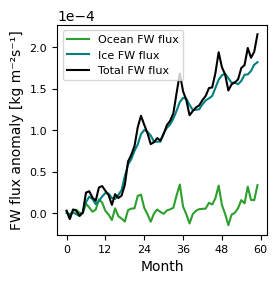

In [50]:
# Plot and calc warm comp freshwater budget using anomalies 
fig, ax0 = plt.subplots(1,1,figsize=(3,3))
window = 1
warm_comp_fw_rm_anom = pd.Series(warm_comp_fw-ens_mean_fw).rolling(window=window).mean()
warm_comp_ice_fw_rm_anom = pd.Series(warm_comp_ice_fw-ens_mean_ice_fw).rolling(window=window).mean()
ax0.plot(warm_comp_fw_rm_anom,label='Ocean FW flux',color='tab:green')
ax0.plot(-warm_comp_ice_fw_rm_anom,label='Ice FW flux',color='teal')
fw_total_anom = warm_comp_fw_rm_anom - warm_comp_ice_fw_rm_anom
ax0.plot(fw_total_anom, label='Total FW flux',color='black')
plt.legend(ncol=1,loc='upper left',fontsize=8)
# plt.grid(True)
ax0.set_xticks(np.arange(0,72,12))
ax0.set_ylabel('FW flux anomaly [kg m⁻²s⁻¹]')
ax0.set_xlabel('Month')
ax0.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# oceFW flux: net surface Fresh-Water flux into the ocean (+=down), >0 decreases salinity
# Ice FW flux: Ice shelf fresh water flux (positive upward), so i flipped the sign so positive downward to match oceFW flux.
i = 0
step = 12 #12 for annual, 6 for bi-annual
print('FW contribution from ice shelf melt')
while i < len(fw_total_anom):
    print('year',(i//step)+1, ': {:.2f}'.format(np.mean(-warm_comp_ice_fw_rm_anom[i:i+step] / fw_total_anom[i:i+step])))
    i += step

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplots_adjust(top=0.9,bottom=0.2,right=0.95,left=0.25)

# save for ic_2001
# plt.savefig('Plots/Figure_ED_4a_FW_decomp.png',dpi=400)

FW contribution from ice shelf melt
year 1 : 0.03
year 2 : 0.70
year 3 : 1.04
year 4 : 0.98
year 5 : 0.97


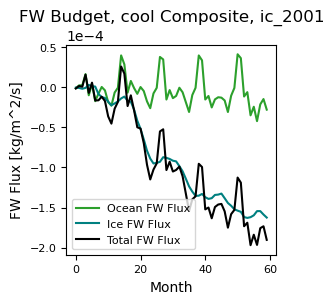

In [53]:
# Plot and calc cool comp freshwater budget using anomalies
fig, ax0 = plt.subplots(1,1,figsize=(3,3))
window = 1
cool_comp_fw_rm_anom = pd.Series(cool_comp_fw-ens_mean_fw).rolling(window=window).mean()
cool_comp_ice_fw_rm_anom = pd.Series(cool_comp_ice_fw-ens_mean_ice_fw).rolling(window=window).mean()
ax0.plot(cool_comp_fw_rm_anom,label='Ocean FW Flux',color='tab:green')
ax0.plot(-cool_comp_ice_fw_rm_anom,label='Ice FW Flux',color='teal')
fw_total_anom = cool_comp_fw_rm_anom - cool_comp_ice_fw_rm_anom
ax0.plot(fw_total_anom, label='Total FW Flux',color='black')
plt.legend(ncol=1,loc='lower left',fontsize=8)
ax0.set_xlabel('Month')
ax0.set_ylabel('FW Flux [kg/m^2/s]')
ax0.set_title('FW Budget, cool Composite, '+exp_set)
ax0.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

i = 0
print('FW contribution from ice shelf melt')
while i < len(fw_total_anom):
    print('year',(i//12)+1, ': {:.2f}'.format(np.mean(-cool_comp_ice_fw_rm_anom[i:i+12] / fw_total_anom[i:i+12])))
    i += 12

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.subplots_adjust(top=0.9,bottom=0.2,right=0.95,left=0.25)